In [31]:
import os
import pickle
import cv2
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

In [32]:
input_dir = 'clf-data'
categories = ['empty', 'not_empty']

data = []
labels = []
for category_idx, category in enumerate(categories):
    for file in os.listdir(os.path.join(input_dir, category)):
        img_path = os.path.join(input_dir, category, file)
        img = cv2.imread(img_path)
        img=cv2.resize(img,(69,30))
        # print(img.shape)
        data.append(img)
        labels.append(category_idx)

In [33]:
data = np.asarray(data)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(6090, 30, 69, 3)
(6090,)


In [34]:
import tensorflow as tf

In [35]:
cv2.imshow("img",data[1])
cv2.waitKey(0)

-1

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

print(x_train.shape)

(4872, 30, 69, 3)


In [37]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)


In [51]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,activation='relu',input_shape=(30,69,3)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,activation='relu'),
     tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    # tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 65, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 61, 32)        25632     
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 59, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 18, 57, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 28, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 9, 28, 64)         0         
                                                      

In [53]:
history = model.fit(x_train, y_train, batch_size=64 ,epochs=5 , validation_data=(x_test,y_test))


Epoch 1/5
77/77 [==============================] - 77s 934ms/step - loss: 0.4772 - accuracy: 0.8192 - val_loss: 0.5083 - val_accuracy: 0.7570
Epoch 2/5
77/77 [==============================] - 36s 465ms/step - loss: 0.3844 - accuracy: 0.8553 - val_loss: 0.3036 - val_accuracy: 0.9007
Epoch 3/5
77/77 [==============================] - 37s 477ms/step - loss: 0.2510 - accuracy: 0.9239 - val_loss: 0.1261 - val_accuracy: 0.9729
Epoch 4/5
77/77 [==============================] - 36s 472ms/step - loss: 0.1360 - accuracy: 0.9645 - val_loss: 0.0683 - val_accuracy: 0.9819
Epoch 5/5
77/77 [==============================] - 37s 480ms/step - loss: 0.0770 - accuracy: 0.9784 - val_loss: 0.0331 - val_accuracy: 0.9885


In [54]:
y_pred=model.predict(x_test)

39/39 [==============================] - 7s 60ms/step


In [55]:
for i in range(1218):
    if y_pred[i]>=0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0

In [56]:
print(y_test)

[1 0 0 ... 0 0 1]


In [57]:
print(y_pred)

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [58]:
from sklearn.metrics import accuracy_score

In [59]:
score = accuracy_score(y_pred, y_test)
print("accuracy score of the custom CONVNet model is :",score*100)

accuracy score of the custom CONVNet model is : 98.85057471264368


In [60]:
df=pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.477230,0.819171,0.508303,0.756979
1,0.384407,0.855296,0.303575,0.900657
2,0.251027,0.923851,0.126070,0.972906
3,0.135954,0.964491,0.068285,0.981938
4,0.077039,0.978448,0.033089,0.988506


<Axes: ylabel='accuracy'>

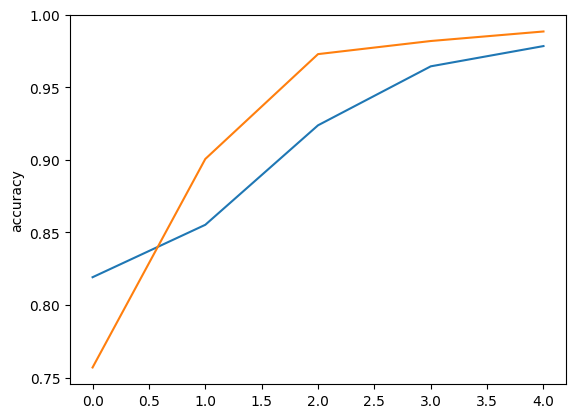

In [61]:
import seaborn as sns
sns.lineplot(df["accuracy"])
sns.lineplot(df["val_accuracy"])

<Axes: ylabel='loss'>

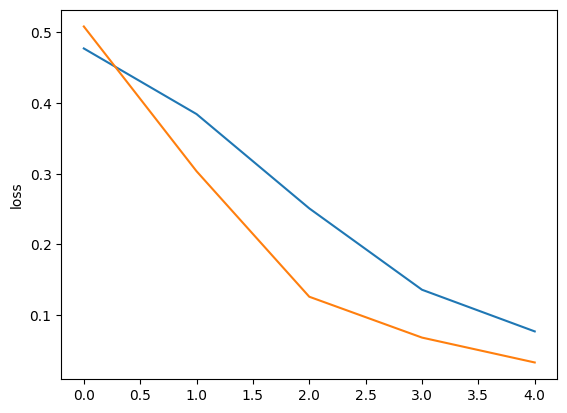

In [62]:
sns.lineplot(df["loss"])
sns.lineplot(df["val_loss"])

In [50]:
import pickle
filename = 'CustomCONVnet.p'
pickle.dump(model, open(filename, 'wb'))